In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sunau
from scipy import signal
from scipy.io import wavfile
import pandas as pd
import pywt
import librosa
import python_speech_features

In [2]:
def loadAudio(audioPath):
    sample_rate, samples = wavfile.read(audioPath)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    spectrogram = np.log(spectrogram)
    transposed_spec = spectrogram.transpose()
    freq_list = list(frequencies)
    #freq_list = [str(f) for f in freq_list]
    #freq_list = [f + " Hz" for f in freq_list]
    audio_df = pd.DataFrame(transposed_spec, index = times, columns = freq_list )
    audio_df.index = times
    audio_df
    return audio_df, samples, sample_rate

In [3]:
def constructSpectrogramFigure(audio_df):
    fig, ax = plt.subplots(figsize=(16, 4))
    im = plt.pcolormesh(audio_df.index, audio_df.columns, audio_df.transpose(), shading='auto')

In [4]:
"""
- A function to normalize a wave
- A function that computes an FFT given a normalized wave, then takes the first half, then returns the magnitude or real or complex part
    - Either accept a normalized wave or call the normalize function on raw wave
- A function to plot the FFT
    - Either pass the FFT as a argument or normalized wave, or call FFT on raw wave, etc
"""
def normalize(samples: np.array) -> np.array:
    normalized_samples = samples/(2**15) #b is now normalized on [-1,1) [we were going to normalize between -1,1 like they had, so we divide by the maximum value permitted by this number of bits (8, 16, 32, ..) minus 1 (for the signed bit)]
    normalized_samples = np.clip(normalized_samples, -1, 1)
    return normalized_samples

#this version returns magnitude of complex fft output
def normFFT(normalized_samples: np.array, n: int =5000) -> (np.array, np.array, np.array):
    """This function takes a normalized numpy array of amplitude measurements, applies a FFT, and returns the magnitudes,
        the real parts, and the imaginary parts of the FFT
    
    Inputs:
        normalized_samples (np.array): an array of floats bounded between -1 and 1
        n: (int): output length for FFT; the length of the resulting arrays will be n/2
    Returns:
        tuple: numpy arrays of the magnitudes of the FFT, the real parts of the FFT, the imaginary parts of the FFT
    """
    transformed_samples = fft(normalized_samples, n=n) # calculate fourier transform (complex numbers list)
    length = len(transformed_samples)/2  # you only need half of the fft list (real signal symmetry)
    halved_transform = transformed_samples[0:int(length-1)]
    return np.abs(halved_transform), np.real(halved_transform), np.imag(halved_transform)

In [10]:
from scipy.fftpack import fft
def constructFFTFigure(abs_fft):
    plt.plot(abs_fft) 
    plt.xlim((0,1000))
    plt.show()

In [7]:
from scipy.signal import butter,filtfilt
def butter_highpass_filter(data, cutoff, sample_rate, order):
    normal_cutoff = cutoff / (0.5 * sample_rate)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [8]:
def butter_lowpass_filter(data, cutoff, sample_rate, order):
    normal_cutoff = cutoff / (0.5 * sample_rate)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [10]:
key_press_path = "C:\\Users\\kbk17\\EspionageDomainExploration\\key_presses.wav"
desk_tap_path = "C:\\Users\\kbk17\\EspionageDomainExploration\\desk_taps.wav"
key_press_df, key_samples, key_sample_rate = loadAudio(key_press_path)
desk_tap_df, desk_samples, desk_sample_rate = loadAudio(desk_tap_path)
print("key SR: " + str(key_sample_rate))
print("desk SR: " + str(desk_sample_rate))

key SR: 44100
desk SR: 44100


In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [63]:
highpass_key_samples = butter_highpass_filter(key_samples, 2000, key_sample_rate, 2)

In [64]:
highpass_key_samples

array([ -6.80659994,  38.37898968,   6.31007286, ..., -20.42804308,
        49.30779467,  -5.91590725])

In [69]:
np.min(highpass_key_samples)


-1809.6709736681667

In [93]:
mask[50]=True
mask[0:100]
for index, m in enumerate(mask[0:100]):
    if m:
        mask[index-50:index]=True
mask[0:100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

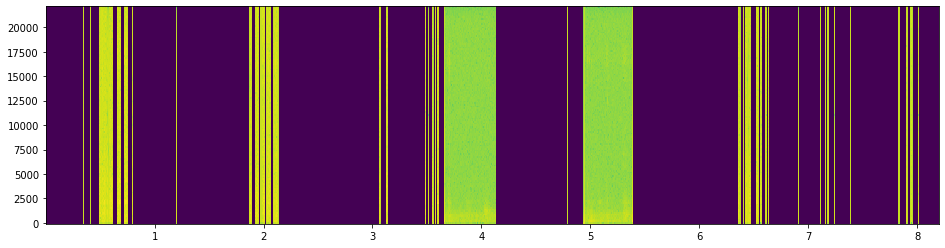

In [97]:
window_size = int(44100/15)
#silence_threshold = 0.01 * (2**15) #un-normalizing
silence_threshold = 0.09
silence = -2**15
key_moving_average = moving_average(highpass_key_samples, window_size)
mask = key_moving_average > silence_threshold

mask_window_size = 15000
for index, m in enumerate(mask):
    if m and mask[index-mask_window_size] == True:
        mask[index-mask_window_size:index] = True


gated_key_samples = np.where(mask, key_samples, silence)
frequencies, times, spectrogram = signal.spectrogram(gated_key_samples, key_sample_rate)
spectrogram = np.log(spectrogram+0.000000000000000000000000000000000000001)
transposed_spec = spectrogram.transpose()
freq_list = list(frequencies)
#freq_list = [str(f) for f in freq_list]
#freq_list = [f + " Hz" for f in freq_list]
gated_key_samples_df = pd.DataFrame(transposed_spec, index = times, columns = freq_list )
gated_key_samples_df.index = times
constructSpectrogramFigure(gated_key_samples_df)

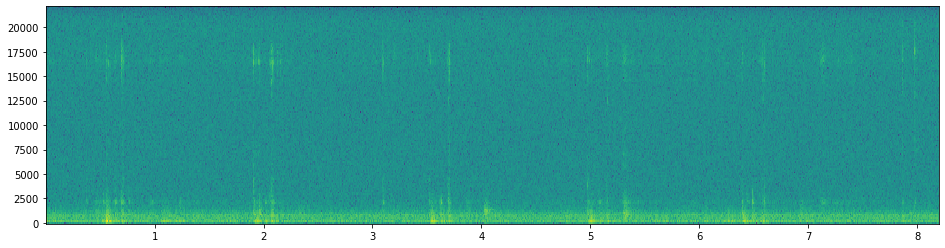

In [58]:
constructSpectrogramFigure(key_press_df)

In [46]:
np.max(key_samples[0:int(0.3*key_sample_rate)])

3379

In [47]:
silence_threshold

540.672

True

In [49]:
truncated_key_samples = key_samples[0:key_samples.shape[0] - window_size - 1]

In [50]:
truncated_key_samples.shape

(352907,)

array([-32768, -32768, -32768, ..., -32768, -32768, -32768], dtype=int16)

In [217]:
np.max(gated_key_samples)

5497

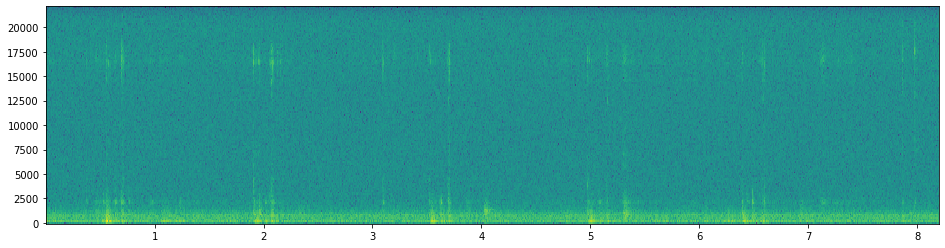

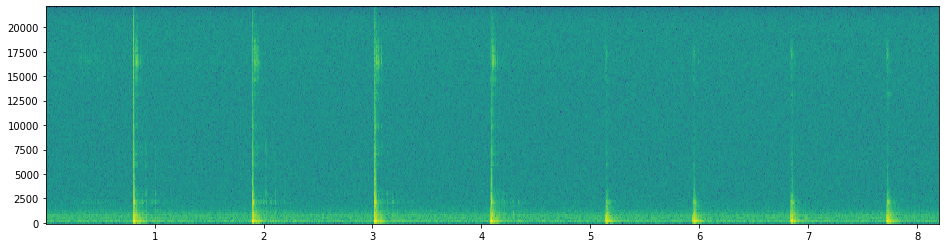

In [213]:
constructSpectrogramFigure(desk_tap_df)

In [68]:
key_press_df

,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,-0.371841,6.041417,4.401316,2.302788,3.807251,4.442738,0.029890,1.125396,0.272385,-0.728449,...,-1.941222,-3.657692,-2.140309,-2.010637,-4.402378,-3.814638,-5.214891,-5.250466,-6.868406,-7.971337
0.007982,1.856777,7.416623,5.937440,4.449966,4.093351,3.254966,3.135251,2.257371,0.763943,-3.104522,...,-1.507935,-4.401024,-2.382209,-2.678179,-3.261879,-3.523154,-4.087964,-4.430175,-5.189734,-10.965137
0.013061,1.425049,8.005643,5.169589,4.021078,2.168130,-1.369860,-2.045325,1.515423,-0.084016,-0.100869,...,-3.283064,-4.784340,-5.387166,-2.231239,-3.537018,-3.441341,-7.188872,-5.805976,-6.008467,-5.402481
0.018141,1.338329,6.808854,3.952198,4.494995,2.764990,3.586932,1.454180,1.021648,0.436486,-0.327461,...,-3.727180,-4.524405,-2.040497,-4.884905,-3.301314,-4.704895,-4.761692,-5.701983,-8.642686,-5.554620
0.023220,-7.684561,4.352694,1.556699,2.756576,1.840332,2.767333,0.940094,0.169108,0.413014,-0.127126,...,-3.760754,-4.019884,-5.272467,-3.597101,-6.587583,-4.476533,-5.935146,-3.699030,-5.002886,-12.028330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.175601,-3.722681,3.268968,1.396249,3.766124,3.314522,3.914415,-1.837740,-3.315286,-1.103070,-1.088073,...,-5.246394,-3.042350,-2.527496,-2.441252,-2.908582,-5.741607,-2.832851,-3.317321,-6.410496,-5.075425
8.180680,-0.903482,3.093395,3.721349,4.029892,2.899930,4.445155,0.609807,-0.090016,-1.235759,-2.692074,...,-3.055157,-3.171123,-2.118035,-5.426893,-3.595520,-8.531733,-5.779421,-4.651508,-8.094835,-6.424826
8.185760,1.656237,4.877682,3.374756,4.486418,3.376268,3.888585,1.638142,-0.337244,-1.760705,-7.420925,...,-2.914598,-2.670786,-4.216448,-1.823179,-3.664914,-5.045464,-4.585584,-5.452651,-5.604866,-8.129479
8.190839,-4.023011,2.877188,3.673476,4.461644,2.827983,3.869554,1.851894,-1.185023,0.523109,-3.278858,...,-1.490122,-7.027619,-3.984778,-2.863932,-5.995823,-5.128712,-5.030776,-3.546202,-4.258037,-6.270360


,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,-11.411681,-14.690059,-14.936702,-15.362722,-15.995474,-16.889582,-18.159290,-20.160724,-28.817592,-22.107489,...,-2.412579,-3.990420,-2.313668,-2.136811,-4.365276,-3.819907,-5.259796,-5.215737,-6.900320,-8.011320
0.007982,-14.119473,-17.403213,-17.647961,-18.072633,-18.707008,-19.612649,-20.915046,-23.010261,-28.211913,-24.728912,...,-2.038135,-4.618860,-2.541505,-2.792668,-3.382811,-3.607236,-4.088844,-4.399769,-5.165433,-11.165563
0.013061,-12.865355,-16.145720,-16.393525,-16.821057,-17.455432,-18.349419,-19.620427,-21.626530,-30.506364,-23.449179,...,-3.662840,-5.277744,-5.825736,-2.364397,-3.564253,-3.460836,-7.332188,-5.868185,-6.041456,-5.392799
0.018141,-12.566855,-15.850360,-16.095793,-16.520022,-17.151396,-18.045055,-19.322733,-21.369430,-28.148095,-23.040155,...,-4.345979,-4.675894,-2.228379,-4.924940,-3.354287,-4.729120,-4.786615,-5.691384,-8.733973,-5.530023
0.023220,-15.046670,-18.312757,-18.566173,-19.002153,-19.645014,-20.541465,-21.792591,-23.657741,-28.133753,-26.376297,...,-4.341883,-4.146397,-5.561266,-3.702737,-6.680425,-4.471727,-5.934329,-3.703279,-4.977948,-11.349188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.175601,-13.578150,-16.857341,-17.100896,-17.522674,-18.151168,-19.043690,-20.319682,-22.350266,-28.268095,-24.266507,...,-5.910782,-3.310842,-2.706951,-2.554399,-2.975588,-5.747989,-2.832898,-3.329973,-6.404013,-5.080233
8.180680,-12.950464,-16.233938,-16.482771,-16.911181,-17.545301,-18.436104,-19.702903,-21.713735,-28.538206,-23.314656,...,-3.487630,-3.416813,-2.338805,-5.703931,-3.614704,-8.773906,-5.823430,-4.652336,-8.014045,-6.460725
8.185760,-14.238572,-17.529262,-17.773704,-18.196844,-18.829061,-19.726013,-21.021583,-23.148228,-27.799303,-24.489539,...,-3.455403,-2.968371,-4.399902,-1.921648,-3.733636,-5.093328,-4.633824,-5.390579,-5.616495,-8.307200
8.190839,-12.800793,-16.075117,-16.322910,-16.750667,-17.384807,-18.276883,-19.542632,-21.502936,-27.992523,-23.678512,...,-1.963850,-7.273360,-4.276398,-2.984495,-5.932579,-5.122967,-5.035706,-3.553461,-4.274601,-6.211191


In [91]:
highpass_key_samples_df.columns[0:7]

Float64Index([0.0, 172.265625, 344.53125, 516.796875, 689.0625, 861.328125,
              1033.59375],
             dtype='float64')

In [92]:
highpass_key_samples_df[highpass_key_samples_df.columns[0:7]] = -48.0
highpass_key_samples_df

,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-20.160724,-28.817592,-22.107489,...,-2.412579,-3.990420,-2.313668,-2.136811,-4.365276,-3.819907,-5.259796,-5.215737,-6.900320,-8.011320
0.007982,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-23.010261,-28.211913,-24.728912,...,-2.038135,-4.618860,-2.541505,-2.792668,-3.382811,-3.607236,-4.088844,-4.399769,-5.165433,-11.165563
0.013061,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-21.626530,-30.506364,-23.449179,...,-3.662840,-5.277744,-5.825736,-2.364397,-3.564253,-3.460836,-7.332188,-5.868185,-6.041456,-5.392799
0.018141,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-21.369430,-28.148095,-23.040155,...,-4.345979,-4.675894,-2.228379,-4.924940,-3.354287,-4.729120,-4.786615,-5.691384,-8.733973,-5.530023
0.023220,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-23.657741,-28.133753,-26.376297,...,-4.341883,-4.146397,-5.561266,-3.702737,-6.680425,-4.471727,-5.934329,-3.703279,-4.977948,-11.349188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.175601,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-22.350266,-28.268095,-24.266507,...,-5.910782,-3.310842,-2.706951,-2.554399,-2.975588,-5.747989,-2.832898,-3.329973,-6.404013,-5.080233
8.180680,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-21.713735,-28.538206,-23.314656,...,-3.487630,-3.416813,-2.338805,-5.703931,-3.614704,-8.773906,-5.823430,-4.652336,-8.014045,-6.460725
8.185760,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-23.148228,-27.799303,-24.489539,...,-3.455403,-2.968371,-4.399902,-1.921648,-3.733636,-5.093328,-4.633824,-5.390579,-5.616495,-8.307200
8.190839,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-48.0,-21.502936,-27.992523,-23.678512,...,-1.963850,-7.273360,-4.276398,-2.984495,-5.932579,-5.122967,-5.035706,-3.553461,-4.274601,-6.211191


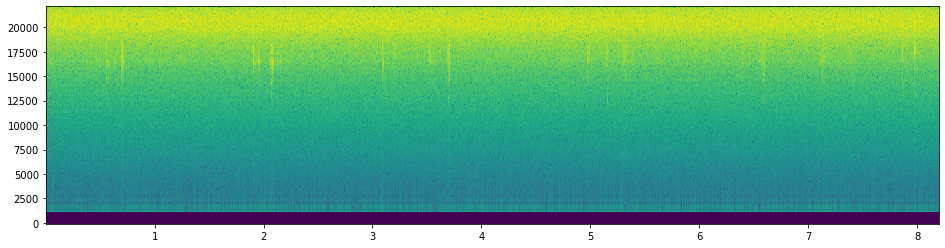

In [93]:
constructSpectrogramFigure(highpass_key_samples_df)

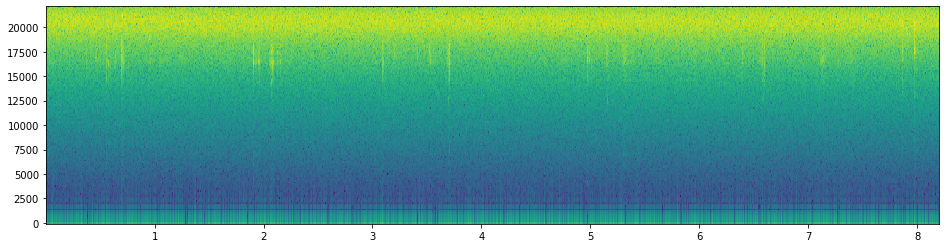

In [85]:
constructSpectrogramFigure(highpass_key_samples_df)

In [86]:
lowpass_key_samples = butter_lowpass_filter(key_samples, 100, key_sample_rate, 2)
frequencies, times, spectrogram = signal.spectrogram(lowpass_key_samples, key_sample_rate)
spectrogram = np.log(spectrogram)
transposed_spec = spectrogram.transpose()
freq_list = list(frequencies)
#freq_list = [str(f) for f in freq_list]
#freq_list = [f + " Hz" for f in freq_list]
lowpass_key_samples_df = pd.DataFrame(transposed_spec, index = times, columns = freq_list )
lowpass_key_samples_df.index = times
lowpass_key_samples_df

,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,-6.063399,6.326196,4.439165,2.524669,-0.862861,-0.449251,0.533618,0.466417,-0.102776,-1.095919,...,-19.273767,-19.214998,-19.710786,-20.803090,-22.576985,-24.429215,-24.141850,-23.474236,-23.987883,-29.751035
0.007982,-0.015637,7.558363,5.620968,3.705779,0.614158,0.944321,1.770123,1.674704,1.092538,0.088636,...,-18.087034,-18.027743,-18.527890,-19.632466,-21.441223,-23.358046,-22.990680,-22.278127,-22.771875,-27.218162
0.013061,1.834682,7.652087,5.540999,3.594380,0.765614,1.220424,1.836336,1.685043,1.070516,0.034215,...,-18.135368,-18.072426,-18.587580,-19.737330,-21.678041,-23.840520,-23.174735,-22.308431,-22.741978,-26.195875
0.018141,0.848209,6.089361,3.691725,1.768154,-0.056031,0.108912,0.299248,0.009910,-0.680865,-1.785934,...,-19.945442,-19.880329,-20.424091,-21.657879,-23.882374,-26.878105,-25.155540,-24.032377,-24.346258,-26.737904
0.023220,-0.210081,5.089606,3.324897,1.528678,-0.942201,-1.304763,-0.606344,-0.692292,-1.252544,-2.221643,...,-20.400886,-20.351259,-20.832187,-21.875028,-23.521050,-25.196891,-25.075494,-24.555302,-25.082887,-28.383141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.175601,-3.094720,2.308432,0.104455,-1.831510,-4.219231,-3.888246,-3.495570,-3.705529,-4.351934,-5.417298,...,-23.591648,-23.525549,-24.052900,-25.240836,-27.308194,-29.836612,-28.774409,-27.758381,-28.150082,-31.367402
8.180680,-1.654870,3.411698,1.415001,-0.396875,-2.320630,-2.501075,-2.255564,-2.479823,-3.113334,-4.144307,...,-22.320242,-22.266843,-22.772332,-23.884374,-25.721522,-27.756709,-27.190850,-26.427647,-26.847432,-29.399203
8.185760,-0.226528,2.545461,-0.868905,-0.860808,-1.261076,-1.827461,-2.621367,-3.639538,-4.901963,-6.374405,...,-24.230606,-24.427606,-24.969831,-25.844168,-27.277335,-30.245497,-27.943023,-27.207917,-27.336309,-28.325267
8.190839,-2.084330,1.472534,-0.236016,-1.719609,-3.105827,-3.709956,-3.848565,-4.188125,-4.830512,-5.809558,...,-24.007805,-23.981976,-24.446980,-25.423237,-26.924642,-28.484643,-28.408737,-27.973611,-28.377925,-30.081742


In [88]:
lowpass_key_samples_df

,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,-6.063399,6.326196,4.439165,2.524669,-0.862861,-0.449251,0.533618,0.466417,-0.102776,-1.095919,...,-19.273767,-19.214998,-19.710786,-20.803090,-22.576985,-24.429215,-24.141850,-23.474236,-23.987883,-29.751035
0.007982,-0.015637,7.558363,5.620968,3.705779,0.614158,0.944321,1.770123,1.674704,1.092538,0.088636,...,-18.087034,-18.027743,-18.527890,-19.632466,-21.441223,-23.358046,-22.990680,-22.278127,-22.771875,-27.218162
0.013061,1.834682,7.652087,5.540999,3.594380,0.765614,1.220424,1.836336,1.685043,1.070516,0.034215,...,-18.135368,-18.072426,-18.587580,-19.737330,-21.678041,-23.840520,-23.174735,-22.308431,-22.741978,-26.195875
0.018141,0.848209,6.089361,3.691725,1.768154,-0.056031,0.108912,0.299248,0.009910,-0.680865,-1.785934,...,-19.945442,-19.880329,-20.424091,-21.657879,-23.882374,-26.878105,-25.155540,-24.032377,-24.346258,-26.737904
0.023220,-0.210081,5.089606,3.324897,1.528678,-0.942201,-1.304763,-0.606344,-0.692292,-1.252544,-2.221643,...,-20.400886,-20.351259,-20.832187,-21.875028,-23.521050,-25.196891,-25.075494,-24.555302,-25.082887,-28.383141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.175601,-3.094720,2.308432,0.104455,-1.831510,-4.219231,-3.888246,-3.495570,-3.705529,-4.351934,-5.417298,...,-23.591648,-23.525549,-24.052900,-25.240836,-27.308194,-29.836612,-28.774409,-27.758381,-28.150082,-31.367402
8.180680,-1.654870,3.411698,1.415001,-0.396875,-2.320630,-2.501075,-2.255564,-2.479823,-3.113334,-4.144307,...,-22.320242,-22.266843,-22.772332,-23.884374,-25.721522,-27.756709,-27.190850,-26.427647,-26.847432,-29.399203
8.185760,-0.226528,2.545461,-0.868905,-0.860808,-1.261076,-1.827461,-2.621367,-3.639538,-4.901963,-6.374405,...,-24.230606,-24.427606,-24.969831,-25.844168,-27.277335,-30.245497,-27.943023,-27.207917,-27.336309,-28.325267
8.190839,-2.084330,1.472534,-0.236016,-1.719609,-3.105827,-3.709956,-3.848565,-4.188125,-4.830512,-5.809558,...,-24.007805,-23.981976,-24.446980,-25.423237,-26.924642,-28.484643,-28.408737,-27.973611,-28.377925,-30.081742


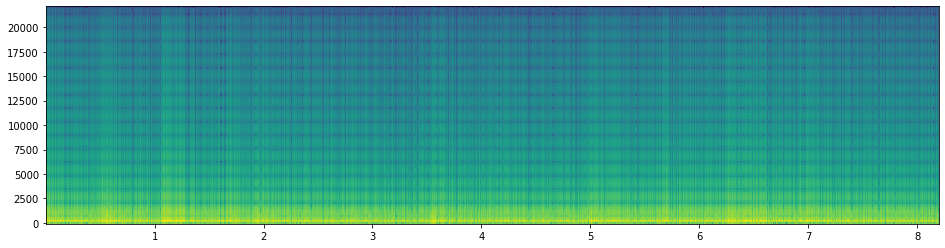

In [87]:
constructSpectrogramFigure(lowpass_key_samples_df)

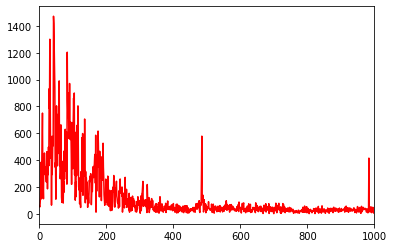

In [115]:
constructFFTFigure(key_samples)

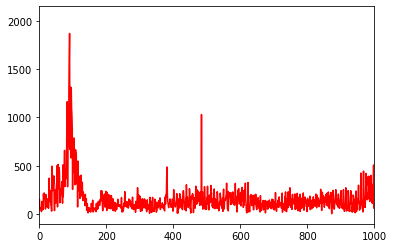

In [116]:
constructFFTFigure(desk_samples)

In [ ]:
c

In [124]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

data = np.array([10,5,8,9,15,22,26,11,15,16,18,7])

print(moving_average(data,4))

[ 8.    9.25 13.5  18.   18.5  18.5  17.   15.   14.  ]


In [122]:
sum([5,8,9,15])/4

9.25

In [ ]:
gat

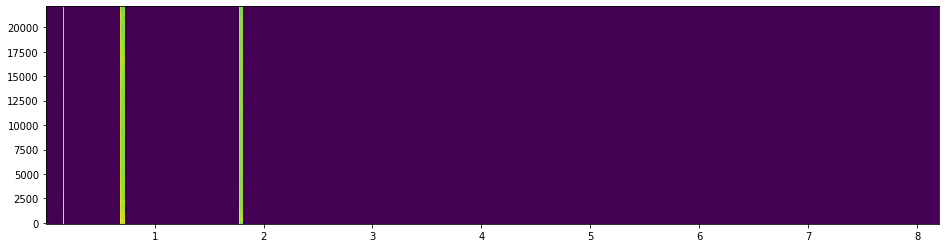

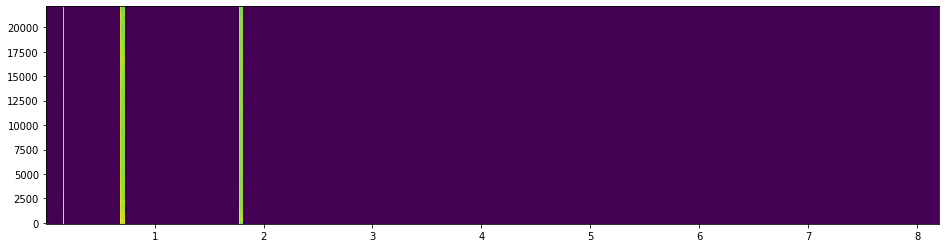

In [54]:
constructSpectrogramFigure(gated_key_samples_df)

In [1]:
!pip install noisereduce

     ---------------------------------------- 78.4/78.4 KB 1.1 MB/s eta 0:00:00
     -------------------------------------- 213.1/213.1 KB 2.2 MB/s eta 0:00:00

You should consider upgrading via the 'c:\users\kbk17\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.



     -------------------------------------- 689.4/689.4 KB 3.6 MB/s eta 0:00:00
     -------------------------------------- 377.5/377.5 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.4/2.4 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 323.4/323.4 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 56.3/56.3 KB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 2.9 MB/s eta 0:00:00
Using legacy 'setup.py install' for audioread, since package 'wheel' is not installed.
Using legacy 'setup.py install' for resampy, since package 'wheel' is not installed.
  Running setup.py install for audioread: started
  Running setup.py install for audioread: finished with status 'done'
  Running setup.py instal

In [ ]:
y : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
      input signal
  sr : int
      sample rate of input signal / noise signal
  y_noise : np.ndarray [shape=(# frames,) or (# channels, # frames)], real-valued
      noise signal to compute statistics over (only for non-stationary noise reduction).
  stationary : bool, optional
      Whether to perform stationary, or non-stationary noise reduction, by default False
  prop_decrease : float, optional
      The proportion to reduce the noise by (1.0 = 100%), by default 1.0
  time_constant_s : float, optional
      The time constant, in seconds, to compute the noise floor in the non-stationary
      algorithm, by default 2.0
  freq_mask_smooth_hz : int, optional
      The frequency range to smooth the mask over in Hz, by default 500
  time_mask_smooth_ms : int, optional
      The time range to smooth the mask over in milliseconds, by default 50
  thresh_n_mult_nonstationary : int, optional
      Only used in nonstationary noise reduction., by default 1
  sigmoid_slope_nonstationary : int, optional
      Only used in nonstationary noise reduction., by default 10
  n_std_thresh_stationary : int, optional
      Number of standard deviations above mean to place the threshold between
      signal and noise., by default 1.5
  tmp_folder : [type], optional
      Temp folder to write waveform to during parallel processing. Defaults to 
      default temp folder for python., by default None
  chunk_size : int, optional
      Size of signal chunks to reduce noise over. Larger sizes
      will take more space in memory, smaller sizes can take longer to compute.
      , by default 60000
      padding : int, optional
      How much to pad each chunk of signal by. Larger pads are
      needed for larger time constants., by default 30000
  n_fft : int, optional
      length of the windowed signal after padding with zeros.
      The number of rows in the STFT matrix ``D`` is ``(1 + n_fft/2)``.
      The default value, ``n_fft=2048`` samples, corresponds to a physical
      duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the
      default sample rate in librosa. This value is well adapted for music
      signals. However, in speech processing, the recommended value is 512,
      corresponding to 23 milliseconds at a sample rate of 22050 Hz.
      In any case, we recommend setting ``n_fft`` to a power of two for
      optimizing the speed of the fast Fourier transform (FFT) algorithm., by default 1024
  win_length : [type], optional
      Each frame of audio is windowed by ``window`` of length ``win_length``
      and then padded with zeros to match ``n_fft``.
      Smaller values improve the temporal resolution of the STFT (i.e. the
      ability to discriminate impulses that are closely spaced in time)
      at the expense of frequency resolution (i.e. the ability to discriminate
      pure tones that are closely spaced in frequency). This effect is known
      as the time-frequency localization trade-off and needs to be adjusted
      according to the properties of the input signal ``y``.
      If unspecified, defaults to ``win_length = n_fft``., by default None
  hop_length : [type], optional
      number of audio samples between adjacent STFT columns.
      Smaller values increase the number of columns in ``D`` without
      affecting the frequency resolution of the STFT.
      If unspecified, defaults to ``win_length // 4`` (see below)., by default None
  n_jobs : int, optional
      Number of parallel jobs to run. Set at -1 to use all CPU cores, by default 1

C:\Users\kbk17\AppData\Local\Temp/ipykernel_11408/3106872685.py:4: RuntimeWarning: divide by zero encountered in log
  spectrogram = np.log(spectrogram)


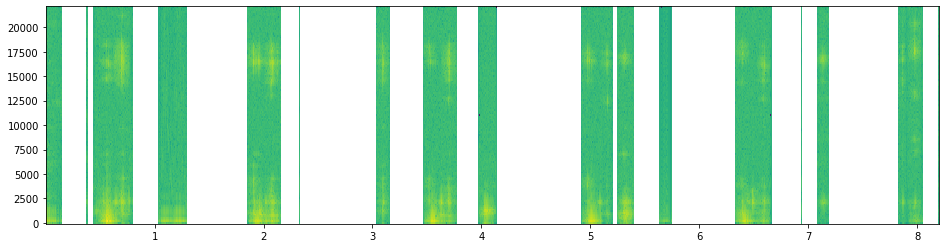

In [49]:
from scipy.io import wavfile
import noisereduce as nr
# load data
key_press_rate, key_press_data = wavfile.read(key_press_path)
desk_tap_rate, desk_tap_data = wavfile.read(desk_tap_path)
bgn_rate, bgn_data = wavfile.read("C:\\Users\\kbk17\\EspionageDomainExploration\\backgroundnoisewithcar.wav")
# perform noise reduction
key_press_reduced_noise = nr.reduce_noise(y=key_press_data, sr=key_press_rate,
                                          y_noise=bgn_data, time_constant_s=0.5,
                                          n_fft=512, thresh_n_mult_nonstationary=3.5,
                                         time_mask_smooth_ms = 75, sigmoid_slope_nonstationary=11)
wavfile.write("key_reduced_noise.wav", key_press_rate, key_press_reduced_noise)
kpr_df, kpr_samples, kpr_sample_rate = loadAudio("key_reduced_noise.wav")
constructSpectrogramFigure(kpr_df)

In [53]:
s = "The quick brown fox jumps     over  the lazy   dog"
s = [x for x in s.split(" ") if x]
s

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [54]:
kpr_samples

array([20, 24, 26, ..., -1,  0, -1], dtype=int16)

In [61]:
np.any(np.isinf(kpr_samples))

False

In [63]:
silence_mask = np.where(kpr_samples == np.min(kpr_samples), True, False)


In [64]:
np.sum(silence_mask)

1

# Switching to Manual Event/Silence Splitting

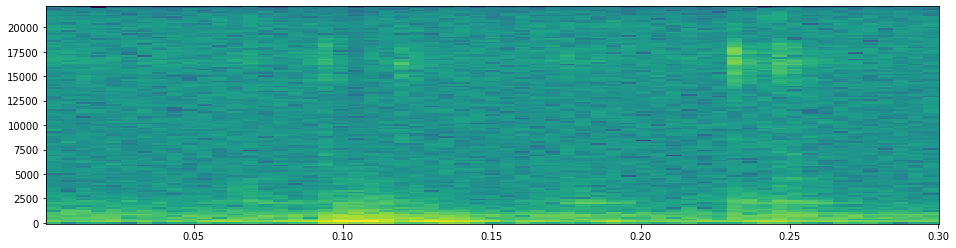

In [65]:
kp1_df, kp1_samples, kp1_sample_rate = loadAudio("C:\\Users\\kbk17\\EspionageDomainExploration\\key_press1.wav")
constructSpectrogramFigure(kp1_df)

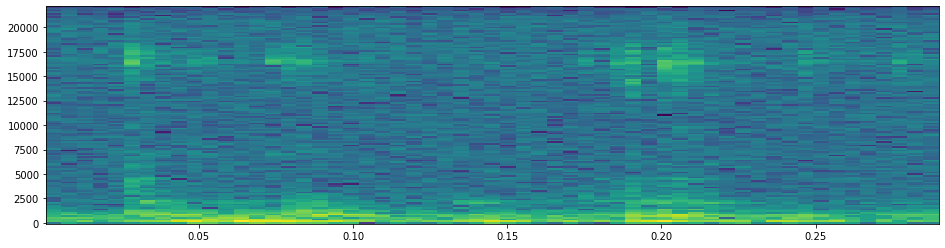

In [66]:
kp2_df, kp2_samples, kp2_sample_rate = loadAudio("C:\\Users\\kbk17\\EspionageDomainExploration\\key_press2.wav")
constructSpectrogramFigure(kp2_df)

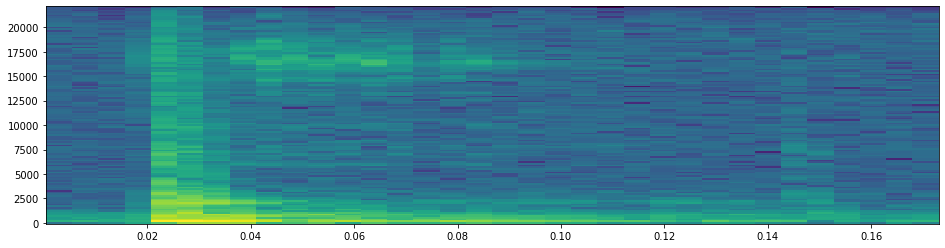

In [71]:
dt2_df, dt2_samples, dt2_sample_rate = loadAudio("C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap2.wav")
constructSpectrogramFigure(dt2_df)

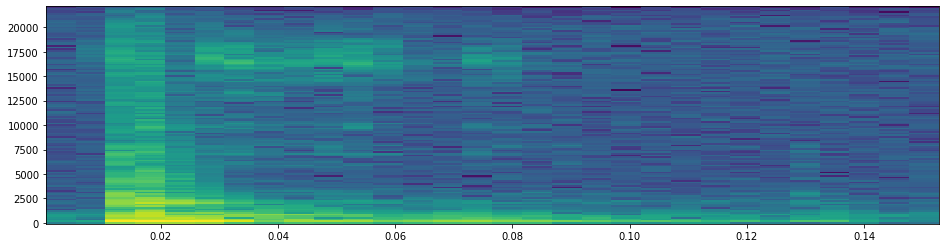

In [72]:
dt3_df, dt3_samples, dt3_sample_rate = loadAudio("C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap3.wav")
constructSpectrogramFigure(dt3_df)

In [63]:
#delet above
import glob

In [6]:
glob.glob("C:\\Users\\kbk17\\EspionageDomainExploration\\*.wav")

['C:\\Users\\kbk17\\EspionageDomainExploration\\backgroundnoisewithcar.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap1.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap2.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap3.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap4.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap5.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap6.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap7.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap8.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_taps.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press1.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press2.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press3.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press4.wav',
 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press5.wav',
 'C:\\Users\\kbk17\\Es

In [6]:
desk_path_list = ['C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap1.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap2.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap3.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap4.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap5.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap6.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap7.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap8.wav']
key_path_list = ['C:\\Users\\kbk17\\EspionageDomainExploration\\key_press1.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press2.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press3.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press4.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press5.wav']

In [7]:
desk_read_output = [loadAudio(x) for x in desk_path_list]
key_read_output = [loadAudio(x) for x in key_path_list]

In [ ]:
"""
Housing Price Estimator

Y ~ X1 + X2 + X3

Y  | X1 | X2 | X3
----------------
600k| 3  | 40 | 53
300k| 2  | 20 | 70
   
Sound Classifier

Y | Hz_1_1 | Hz_2_1 | ... | Hz_1_2 | Hz_2_2 | .... 
-----------------
D |
K |

Using all frequencies at all time points would give about 400 million columns
How can we reduce the number of columns?
(1) Bin or combine frequencies together
(2) Apply a banded filter 5k-12.5k

"""

In [99]:
df, samples, sample_rate = key_read_output[4]

In [100]:
df

,0.000000,172.265625,344.531250,516.796875,689.062500,861.328125,1033.593750,1205.859375,1378.125000,1550.390625,...,20499.609375,20671.875000,20844.140625,21016.406250,21188.671875,21360.937500,21533.203125,21705.468750,21877.734375,22050.000000
0.002902,2.829410,10.679458,7.979804,6.820292,7.211168,5.946972,-0.094305,4.317117,3.876759,3.669539,...,-0.351169,0.511550,1.470147,1.024148,-1.077135,-1.746169,-0.550373,-1.435458,-2.071756,-2.935029
0.007982,4.472490,6.379100,6.902576,4.451651,8.053487,7.169592,4.943622,4.679177,2.691847,3.559330,...,-1.240961,-0.358953,1.435836,0.286078,-1.953525,1.095439,0.617225,-0.226738,-1.699761,-8.208544
0.013061,4.191556,9.033637,8.117625,2.965651,7.525947,7.613647,2.439267,4.474599,2.281137,1.446160,...,-1.570573,-2.742157,0.623273,-0.215136,0.943614,-1.007851,-0.526741,-2.547287,-1.129017,-1.764186
0.018141,4.557675,8.625685,6.802719,6.526761,3.627497,6.377215,4.467554,3.261983,1.709213,0.550518,...,-0.271931,1.899472,1.892289,-1.026832,-0.933601,1.106751,-0.654281,-0.690316,-1.421361,-3.416383
0.023220,3.637483,7.093050,6.154863,5.650524,5.097305,5.940014,5.416519,3.188186,2.881891,2.173964,...,1.776866,0.820583,1.193447,-0.315293,0.301475,1.211605,-1.541114,0.414894,-1.541732,-1.230520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.297506,5.406463,10.938206,4.180389,8.074655,7.745565,8.639402,2.705926,3.784534,3.082072,2.922736,...,0.251175,2.270038,1.571254,1.451736,-0.574921,-0.374301,-1.116854,-1.277557,-2.417099,-3.696483
0.302585,5.956712,8.837889,7.108362,4.106261,6.174274,7.603860,5.578620,4.089711,4.128257,2.630120,...,0.022861,0.176454,0.509968,-0.271035,-3.915177,-0.174970,-0.131197,-3.771240,-2.853814,-1.812549
0.307664,3.398823,9.700239,7.122565,5.969110,5.932185,7.329558,5.074160,3.097748,3.119166,3.784518,...,1.124114,-0.065650,0.910050,0.406293,0.573664,0.485674,-0.518776,-5.404471,-0.293725,-5.029614
0.312744,6.136640,9.394977,5.616365,6.272712,8.284034,2.583125,6.335469,4.993198,-1.396621,2.355790,...,0.267796,0.205679,-2.037393,0.414521,0.205774,-2.037512,-0.715834,-0.533121,-1.050155,-3.344334


In [93]:
df.to_numpy().flatten()

array([-0.45295805,  2.6245775 ,  1.9154459 , ..., -5.8428874 ,
       -5.502367  , -8.00389   ], dtype=float32)

In [87]:
129*29

3741

In [13]:
waveforms = []
for df, samples, sample_rate in key_read_output + desk_read_output:
    waveforms.append(samples)

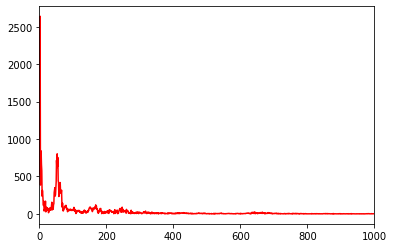

In [12]:
constructFFTFigure(waveforms[0])

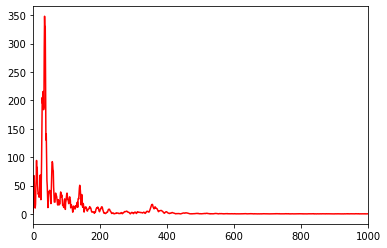

In [14]:
constructFFTFigure(waveforms[-1])

In [28]:
array = normFFT(waveforms[3])
array.shape

(2499,)

In [29]:
longest = 0
for w in waveforms:
    if len(w) > longest:
        longest=len(w)
longest

14262

In [47]:
ffts = [normFFT(w, 14262) for w in waveforms]

In [48]:
[len(x) for x in ffts]

[7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130, 7130]

In [49]:
X_train = np.vstack(ffts)
# 0 corresponds to keypress, 1 to desktap
y_train = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
X_train.shape

(13, 7130)

In [53]:
X_train

array([[5.38963135e+02, 1.51362942e+03, 2.77268686e+03, ...,
        1.47205117e-01, 2.50236100e-01, 2.60357564e-01],
       [5.23357330e+02, 7.50896609e+02, 9.03197304e+02, ...,
        8.76598486e-02, 3.78997033e-02, 1.75734625e-01],
       [1.41549744e+02, 3.22050536e+02, 4.46460479e+02, ...,
        9.65089149e-02, 2.20919219e-01, 2.35339819e-01],
       ...,
       [2.39297485e+00, 9.16650759e+00, 2.47507453e+01, ...,
        4.71500227e-02, 8.40912049e-03, 2.80426651e-02],
       [3.56314087e+00, 4.13013258e+01, 4.69824297e+01, ...,
        1.64463240e-02, 4.69507003e-02, 2.99666555e-02],
       [2.75354004e+00, 2.82719431e+01, 2.11539691e+01, ...,
        1.41243059e-02, 3.66189131e-02, 3.46236315e-02]])

In [61]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

In [62]:
clf.predict(X_train)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [59]:
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline(MinMaxScaler(), LogisticRegression())
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

In [60]:
lr_clf.predict(X_train)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
test_paths = glob.glob("C:\\Users\\kbk17\\EspionageDomainExploration\\Test_Cases\\*.wav")

In [67]:
test_audio = [loadAudio(path) for path in test_paths]

C:\Users\kbk17\AppData\Local\Temp/ipykernel_7200/3106872685.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, samples = wavfile.read(audioPath)


In [68]:
X_test = [normFFT(samples,14262) for df, samples, sample_rate in test_audio]

In [69]:
lr_clf.predict(X_test)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [70]:
clf.predict(X_test)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
lr_clf.predict_proba(X_test)

array([[2.06451811e-02, 9.79354819e-01],
       [1.91375166e-04, 9.99808625e-01],
       [2.40344271e-03, 9.97596557e-01],
       [9.67888327e-01, 3.21116726e-02],
       [2.94888318e-02, 9.70511168e-01],
       [2.20415535e-02, 9.77958446e-01],
       [7.49127374e-03, 9.92508726e-01],
       [6.58155739e-03, 9.93418443e-01],
       [7.33790115e-03, 9.92662099e-01],
       [8.17715613e-03, 9.91822844e-01],
       [1.07439677e-02, 9.89256032e-01],
       [7.45532545e-03, 9.92544675e-01],
       [9.30269105e-03, 9.90697309e-01],
       [1.13993681e-02, 9.88600632e-01],
       [2.08406918e-02, 9.79159308e-01],
       [1.07034462e-02, 9.89296554e-01],
       [1.20816974e-02, 9.87918303e-01],
       [7.46304748e-03, 9.92536953e-01],
       [6.17731160e-03, 9.93822688e-01],
       [7.20741075e-03, 9.92792589e-01],
       [1.42252531e-02, 9.85774747e-01]])

In [73]:
lr_clf.predict_proba(X_train)

array([[9.97276813e-01, 2.72318691e-03],
       [9.96242022e-01, 3.75797808e-03],
       [9.94078270e-01, 5.92173016e-03],
       [9.91591772e-01, 8.40822844e-03],
       [9.94645741e-01, 5.35425943e-03],
       [9.27877538e-03, 9.90721225e-01],
       [2.36347197e-03, 9.97636528e-01],
       [1.46805432e-03, 9.98531946e-01],
       [8.50618102e-04, 9.99149382e-01],
       [3.34042894e-03, 9.96659571e-01],
       [3.22946436e-03, 9.96770536e-01],
       [2.60865386e-03, 9.97391346e-01],
       [3.00432456e-03, 9.96995675e-01]])

In [74]:
from sklearn import tree

In [75]:
tree_clf = make_pipeline(MinMaxScaler(), tree.DecisionTreeClassifier())
tree_clf.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [76]:
tree_clf.predict(X_train)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [77]:
tree_clf.predict(X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
tree_clf.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [1]:
#troubleshooting

In [5]:
#this version returns real part of complex fft output
def normFFT2(samples, n=5000):
    b=[(ele/2**15.) for ele in samples] #b is now normalized on [-1,1) [we were going to normalize between -1,1 like they had, so we divide by the maximum value permitted by this number of bits (8, 16, 32, ..) minus 1 (for the signed bit)]
    b = np.clip(b, -1, 1)
    c = fft(b, n=n) # calculate fourier transform (complex numbers list)
    d = len(c)/2  # you only need half of the fft list (real signal symmetry)
    return np.real(c[0:int(d-1)])